In [ ]:
#@markdown Configuración Inicial

import os, sys
from IPython.utils import io
from IPython.display import display, display_svg
from IPython.display import Math, Latex
from IPython.display import IFrame, HTML
import time
from datetime import datetime as dt
from pytz import timezone
import random, string

prefix = 'Parallel'
configdict = {
    'Serialpc': "DISABLE_JIT: 1",
    'Parallel': "DISABLE_JIT: 0\n"
                "NUM_THREADS: 2\n"
                "THREADING_LAYER: 'tbb'"
}

################################################################################

workdir = prefix +\
          dt.now(timezone('America/Bogota')).strftime('_%y%m%d-%H%M_') +\
          ''.join(random.sample(string.hexdigits, 4)
          )
os.mkdir(workdir)
os.chdir(workdir)
print('Working Directory:', os.getcwd(), sep='\n')
with open('.numba_config.yaml','w') as cf:
  cf.write(configdict[prefix])
  print('Numba Config:', configdict[prefix], sep='\n', end='\n\n')

################################################################################

# https://stackoverflow.com/a/57883792
# https://stackoverflow.com/a/57113015
with io.capture_output() as cap:
  !pip install tbb
  !pip install setuptools
  # https://matplotlib-axes-aligner.readthedocs.io/en/latest/
  !pip install mpl-axes-aligner
  !pip install watermark
  !pip install tqdm --upgrade
  !pip install gradio

with open('pip_installs.txt', 'w') as f:
    f.write(cap.stdout)
!pip freeze > requirements.txt

################################################################################

import pandas as pd
import numpy as np
from numba import njit, prange, config
from numba.np.extensions import cross2d

if config.DISABLE_JIT==1:
  cross2d = np.cross
  prange = range
  print('JIT DISABLED!')
else:
  print('JIT!')
from IPython.display import set_matplotlib_formats

from numpy import linalg as LA
from numpy import random as rg
from scipy.interpolate import interp1d
from scipy import constants as const
from scipy import stats as st

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')


from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib import colors as pltcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
# https://matplotlib-axes-aligner.readthedocs.io/en/latest/
from mpl_axes_aligner import align

import gradio as gr
from tqdm.auto import trange, tqdm
from pprint import pprint

from sympy import Point, Polygon

#https://github.com/rasbt/watermark
%reload_ext watermark
%watermark -v -iv -m

!lscpu
!nvidia-smi

Working Directory:
/content/Parallel_211122-2102_aE53
Numba Config:
DISABLE_JIT: 0
NUM_THREADS: 2
THREADING_LAYER: 'tbb'

JIT!
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython         : 5.5.0
sys             : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
plotly          : 4.4.1
scipy           : 1.4.1
numpy           : 1.19.5
numba           : 0.51.2
matplotlib      : 3.2.2
mpl_axes_aligner: 1.3
gradio          : 2.4.6
pandas          : 1.1.5

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R

In [ ]:
#@markdown Definición de Funciones

@njit(
  fastmath=True,
  error_model='numpy',
  )
def inner_angle(Model, i):
  k = len(Model)
  prev = Model[(i-1)%k]
  next = Model[(i+1)%k]
  here = Model[i%k]
  vetcs = prev-here, next-here
  #https://stackoverflow.com/a/14067171
  return -np.arctan2(
      cross2d(*vetcs),
      np.dot(*vetcs)
      )

@njit(
  fastmath=True,
  error_model='numpy',
  )
def grav(Model, XZ):
  k = len(Model)
  lenXZ = len(XZ)
  xietalist = [Model-XZ[i] for i in prange(lenXZ)]
  lenxieta = len(xietalist)
  grav = np.empty(lenxieta)
  for j in prange(lenxieta):
    xi = xietalist[j].T[0]
    eta = xietalist[j].T[1]
    sum = 0
    for i in prange(k):
      A = (xi[i-1]*eta[i] - xi[i]*eta[i-1])/\
          ((xi[i]-xi[i-1])**2 + (eta[i]-eta[i-1])**2)
      B1 = 0.5*(eta[i] - eta[i-1])*\
           np.log((xi[i]**2 + eta[i]**2)/\
          (xi[i-1]**2 + eta[i-1]**2))
      B2 = (xi[i] - xi[i-1])*\
           (np.arctan(xi[i]/eta[i])-\
           np.arctan(xi[i-1]/eta[i-1]))
      sum += A*(B1+B2)
    grav[j] = sum
  return grav

class Model(np.ndarray):
  def __new__(cls, input_array,*args,**kargs):
    return np.asarray(input_array).astype(np.float).view(cls)
  def __str__(self):
    return ','.join(map(str,self.flatten()))
  def area(self):
    # https://stackoverflow.com/a/30408825
    (x,z) = self.T
    return -0.5*(np.dot(x,np.roll(z,1))-np.dot(np.roll(x,1),z))
  def Cgeom(self):
    return np.array(np.mean(self,axis=0))
  def Cmass(self):
    # https://en.wikipedia.org/wiki/Centroid#Of_a_polygon
    k = self.__len__()
    A = self.area()
    (x,z) = self.T
    Cx = np.array(
        [(x[i%k] + x[(i+1)%k])*\
         (x[i%k]*z[(i+1)%k] - x[(i+1)%k]*z[i%k])\
         for i in range(k)]).sum()/A/6
    Cz = np.array(
        [(z[i%k] + z[(i+1)%k])*\
         (x[i%k]*z[(i+1)%k] - x[(i+1)%k]*z[i%k])\
         for i in range(k)]).sum()/A/6
    return np.array([Cx, Cz])
  def move(self, i, r, th):
    k = self.__len__()
    new = self.copy()
    new[i%k] = self[i%k] + r*np.array([np.cos(th), np.sin(th)])
    return new
  def birth(self, i, r, th):
    k = self.__len__()
    p = (self[i%k]+self[(i+1)%k])/2
    return np.insert(self, (i+1)%k, p, axis=0).move(i+1, r, th)
  def death(self, i):
    k = self.__len__()
    return np.delete(self, i%k, axis=0)
  def dvector(self, i):
    k = self.__len__()
    return np.array(
        (self[(i+1)%k] + self[(i-1)%k])/2-
        self[i%k]
        )
  def dradius(self,i):
    return norm(self.dvector(i))
  def dcat(self,i):
    k = self.__len__()
    return norm(self[(i+1)%k] - self[(i-1)%k])/2
  def bcat(self,i):
    k = self.__len__()
    return norm(self[(i+1)%k] - self[i%k])/2
  def vectors(self, i):
    k = self.__len__()
    prev = self[(i-1)%k]
    next = self[(i+1)%k]
    here = self[i%k]
    return np.array([prev-here, next-here])
  @njit(
    fastmath=True,
    error_model='numpy',
    )
  def angle(self, i):
    return inner_angle(self, i)
  def dists(self, i):
    mapvects = map(norm, self.vectors(i))
    return np.fromiter(mapvects, dtype=np.float)
  @njit(
    fastmath=True,
    error_model='numpy',
    )
  def gravitational(self, XZ, rho=600):
    g = grav(self, XZ)
    return np.column_stack((XZ, g))
  def notintersect(self):
  # https://github.com/lycantropos/bentley_ottmann 
  # Shamos-Huey algorithms 
   return not contour_self_intersects(
      bContour(list(map(lambda _: bPoint(*_), self))
      ))
   
def RegularModel(p, r, phi=np.pi/2, n=3):
  ths = phi+np.linspace(
      0, -2*np.pi, n,
      endpoint=False
      )
  return Model(
      [p + r*np.array([np.cos(th), np.sin(th)]) for th in ths])
   
def str2Model(str):
  return Model(eval(str)).reshape(-1, 2)

def Model_from_file(filename):
  with open(filename, 'r') as file:
    l = list(map(str2Model, file.readlines()))
    if len(l)==1:
      return l[0]
    else:
      return l
    file.close()

def Model_from_GeoGebra(filename):
  return Model(np.genfromtxt(filename))

def xz_iterp(XZ, xx, kind='cubic'):
  zz = interp1d(*XZ.T, kind='cubic')(xx)
  return np.c_[xx, zz]


print('Listo')

Listo


In [ ]:
%%file ../TrueModel_from_GeoGebra.tsv
188	-95
193	-76
219	-72
228	-50
252	-54
265	-71
265	-93
239	-95
229	-119
204	-116

Overwriting ../TrueModel_from_GeoGebra.tsv


In [ ]:
#@markdown Copia y pega la tabla de los vértices separados por tabulaciones para cambiar la forma del modelo de prueba
IFrame("https://www.geogebra.org/classic/cumzsmxp", 1200, 500)

Eye Model:



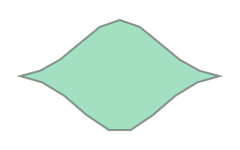

In [ ]:
def Model_eye(s, q=(1,1), d=(0,0), N=19):
  m = N//2
  n = (N-m)
  q = np.array(q)/2
  gauss = st.norm(0, 1/s) 
  f = lambda x: (gauss.pdf(x)-gauss.pdf(1))/\
                (gauss.pdf(0)-gauss.pdf(1))
  ii = np.r_[-1:+1:(n+1)*1j]
  jj = np.r_[+1:-1:(m+1)*1j]
  top    = np.c_[ii, +f(ii)][:-1]
  bottom = np.c_[jj, -f(jj)][:-1]
  eye = q*np.r_[top, bottom] + d
  return Model(eye)

eye_Model = Model_eye(2.5, (200, 200*9/16), (200, -100))
print('Eye Model:\n')
display_svg(Polygon(*map(Point, eye_Model)))

,divide,over,under,invalid
old_settings,warn,warn,ignore,warn
new_settings,raise,ignore,ignore,raise


sigma: 0.2
gamma: 1.6
Maxk: 20
ang: 6.283185307179586
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.5        0.5        0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.5        0.         0.5       ]]
True Model:



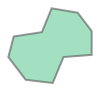

CPU times: user 1.85 s, sys: 38.2 ms, total: 1.88 s
Wall time: 1.88 s


In [ ]:
#@markdown Settings
%%time

sigma = 0.2
gamma = 1.6
Maxk  = 20
ang   = 2*np.pi

old_settings = np.geterr()
new_settings = {
    'divide':  'raise',
    'invalid': 'raise',
    'over':    'ignore',
    'under':   'ignore'
    }
settlist = ['old_settings','new_settings']
display(pd.DataFrame(
    list(map(eval, settlist)),
    index=settlist
    ))
"""
ignore: Take no action when the exception occurs.
warn: Print a RuntimeWarning (via the Python warnings module).
raise: Raise a FloatingPointError.
call: Call a function specified using the seterrcall function.
print: Print a warning directly to stdout.
log: Record error in a Log object specified by seterrcall.
"""

GeoGebraModel = Model_from_GeoGebra('../TrueModel_from_GeoGebra.tsv')
TrueModel = GeoGebraModel # GeoGebraModel, eye_Model

w = np.ones(Maxk)
b = np.ones(Maxk)
d = np.ones(Maxk)
b[-1] = 0
d[2] = 0
ps = np.array([list(p/sum(p)) for p in np.stack((w,b,d)).T])
ps[0:2][:] = np.zeros((2,3))

print('sigma:', sigma)
print('gamma:', gamma)
print('Maxk:', Maxk)
print('ang:', ang)
print(ps)


XZ = (lambda a:
      np.c_[0:500:a,
            4*(1.5+np.cos(2*np.r_[0:2*np.pi:a]))]
      )(26j)

XZg = TrueModel.gravitational(XZ)
g = XZg[:,-1]
np.savetxt(
    '../Gravity.tsv',
    XZg,
    delimiter='\t',
    fmt='%.6g'
    )

XZmin = XZ
XZgrid = xz_iterp(XZ, np.r_[0:500:1001j])

try:
  print('True Model:\n')
  display_svg(Polygon(*map(Point, TrueModel.copy())))
except:
  print('Error or Polygon has intersecting sides.')

Xg    = TrueModel.gravitational(XZgrid)[:,(0,-1)]
Xgmin = TrueModel.gravitational(XZmin)[:,(0,-1)]

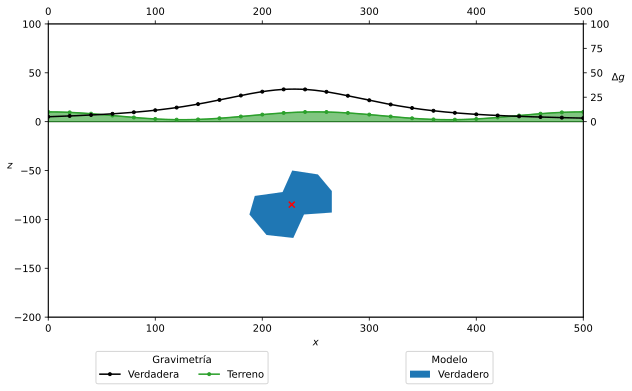

In [ ]:
#@markdown Plot in 0

fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5)
ax_z.tick_params(
    top=True,
    labeltop=True
    )
ax_g = ax_z.twinx()
ax_z.axhline(c='k', lw=1, zorder=0)

ax_g.plot(
    *Xg.T,
    color='k'
    )
ax_g.scatter(
    *Xgmin.T,
    marker='.',
    color='k'
    )
lineg = Line2D(
  [0],[0],
  marker='.',
  color='k',
  label='Verdadera'
  )

ax_z.plot(
    *XZgrid.T,
    color='tab:green',
    label='_nolegend_'
)
ax_z.fill_between(
    *XZgrid.T,
    color='tab:green',
    alpha=3/5
)
ax_z.scatter(
    *XZmin.T,
    marker='.',
    color='tab:green',
    label='_nolegend_'
)
linez = Line2D(
  [0],[0],
  marker='.',
  color='tab:green',
  label='Terreno'
  )

Truepoly = patches.Polygon(
    TrueModel,
    closed=True,
    Fill=True,
    edgecolor=None,
    label='Verdadero'
    )
ax_z.add_patch(Truepoly)

ax_z.scatter(
    *TrueModel.Cmass(),
    marker='x',
    color='r',
    zorder=2
    )

ax_z.set_xlabel(r'$x$')
ax_z.set_ylabel(r'$z$', rotation=0)
ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

ax_z.set_xlim(0, 500)
ax_z.set_ylim(ymin=-200)
ax_g.set_yticks(np.r_[0:100:5j])
align.yaxes(ax_z, 0, ax_g, 0, 2/3)

ax_g.legend(
    handles=[lineg, linez],
    title='Gravimetría',
    bbox_to_anchor=(0.25, -.1),
    ncol=3,
    loc='upper center'
    )
ax_z.legend(
    handles=[Truepoly],
    title='Modelo',
    bbox_to_anchor=(0.75, -.1),
    ncol=2,
    loc='upper center'
    )
plt.savefig('InitPlot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
!cat ../Gravity.tsv

0	10	5.00469
20	9.50523	5.81984
40	8.14331	6.80133
60	6.25116	8.02252
80	4.29688	9.59481
100	2.76393	11.6699
120	2.03154	14.4198
140	2.28089	17.9639
160	3.4503	22.2207
180	5.25047	26.7409
200	7.23607	30.6812
220	8.91587	33.0171
240	9.87433	32.9741
260	9.87433	30.536
280	8.91587	26.4886
300	7.23607	21.8943
320	5.25047	17.5795
340	3.4503	13.9663
360	2.28089	11.1482
380	2.03154	9.03614
400	2.76393	7.47582
420	4.29688	6.31369
440	6.25116	5.42419
460	8.14331	4.71545
480	9.50523	4.12576
500	10	3.61728


In [ ]:
#@title Gradio
examples = [
["""56	-54
106	-31
154	-34
196	-52
207	-82
181	-96
163	-120
124	-120
81.	-98
58.	-69"""],
["""108	-108
144	-48
192	-96
120	-120
96	-192
48	-144"""]
]

data = examples[0][0]
def my_fun(data):
  df=pd.DataFrame([x.split('\t') 
  for x in data.split('\n')], dtype=np.float)
  TrueModel=Model(df)

  XZ = (lambda a:
      np.c_[0:500:a,
            4*(1.5+np.cos(2*np.r_[0:2*np.pi:a]))]
      )(26j)

  XZmin = XZ
  XZgrid = xz_iterp(XZ, np.r_[0:500:1001j])

  Xg    = TrueModel.gravitational(XZgrid)[:,(0,-1)]
  Xgmin = TrueModel.gravitational(XZmin)[:,(0,-1)]

  fig, ax_z = plt.subplots(figsize=np.array([16,9])*3/5)
  ax_z.tick_params(
      top=True,
      labeltop=True
      )
  ax_g = ax_z.twinx()
  ax_z.axhline(c='k', lw=1, zorder=0)

  ax_g.plot(
      *Xg.T,
      color='k'
      )
  ax_g.scatter(
      *Xgmin.T,
      marker='.',
      color='k'
      )
  lineg = Line2D(
    [0],[0],
    marker='.',
    color='k',
    label='Verdadera'
    )

  ax_z.plot(
      *XZgrid.T,
      color='tab:green',
      label='_nolegend_'
  )
  ax_z.fill_between(
      *XZgrid.T,
      color='tab:green',
      alpha=3/5
  )
  ax_z.scatter(
      *XZmin.T,
      marker='.',
      color='tab:green',
      label='_nolegend_'
  )
  linez = Line2D(
    [0],[0],
    marker='.',
    color='tab:green',
    label='Terreno'
    )

  Truepoly = patches.Polygon(
      TrueModel,
      closed=True,
      Fill=True,
      edgecolor=None,
      label='Verdadero'
      )
  ax_z.add_patch(Truepoly)

  ax_z.scatter(
      *TrueModel.Cmass(),
      marker='x',
      color='r',
      zorder=2
      )

  ax_z.set_xlabel(r'$x$')
  ax_z.set_ylabel(r'$z$', rotation=0)
  ax_g.set_ylabel(r'$\quad\Delta{g}$', rotation=0, y=5/6)

  ax_z.set_xlim(0, 500)
  ax_z.set_ylim(ymin=-200)
  ax_g.set_yticks(np.linspace(0, 100, 5))
  align.yaxes(ax_z, 0, ax_g, 0, 2/3)

  ax_g.legend(
      handles=[lineg, linez],
      title='Gravimetría',
      bbox_to_anchor=(0.25, -.1),
      ncol=3,
      loc='upper center'
      )
  ax_z.legend(
      handles=[Truepoly],
      title='Modelo',
      bbox_to_anchor=(0.75, -.1),
      ncol=2,
      loc='upper center'
      )
  fig.tight_layout()
  plt.close()
  return fig

title = "Metodo Directo"
description = 'Copia y pega la tabla de los vértices separados por tabulaciones para cambiar la forma del modelo de prueba'
article = """<p style='text-align: center'>
    <iframe id="inlineFrameExample"
    title="Inline Frame Example"
    width="1000"
    height="400"
    src="https://www.geogebra.org/classic/cumzsmxp">
    </iframe>
    <a href='https://edwardptera.github.io/Gravimetro/'>Gravimetro</a> | 
    <a href='https://github.com/edwardptera/Gravimetro'>Github</a>
    </p>"""

articl0 = """<p style='text-align: center'>
    <a href='https://edwardptera.github.io/Gravimetro/'>Gravimetro</a> | 
    <a href='https://github.com/edwardptera/Gravimetro'>Github</a>
    </p>"""


grtest = gr.Interface(
    fn=my_fun,
    inputs=gr.inputs.Textbox(
        lines=11,
        placeholder=data,
        # default=data
        ),
    # inputs=gr.inputs.Dataframe(
    #     col_count=2,
    #     # default=w,
    #     datatype='number'
    #     ),
    outputs='plot',
    live=True,
    allow_flagging=False,
    allow_screenshot=False,
    title=title,
    description=description,
    article=article,
    examples=examples,
    theme='huggingface', # "default", "compact" or "huggingface"
    layout='unaligned' # 'horizontal', 'unaligned', 'vertical'
    )
# grtest.launch(inline=True, debug=True)
with io.capture_output() as captured:
    grtest.launch(inline=True)
print(grtest.share_url)
IFrame(src=grtest.share_url, width=1500, height=700)
# grtest.close()

https://47988.gradio.app


In [ ]:
#@markdown Archivo `.zip`

!rm -f zfiles.zip
!7z a -bso0 ../{workdir}.zip *.* -x!*.zip
!7z l ../{workdir}.zip

  0M Scan             0%    
7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../             1 file, 27329 bytes (27 KiB)

Listing archive: ../Parallel_211122-2102_aE53.zip

--
Path = ../Parallel_211122-2102_aE53.zip
Type = zip
Physical Size = 27329

   Date      Time    Attr         Size   Compressed  Name
------------------- ----- ------------ ------------  ------------------------
2021-11-23 02:03:13 .....        29116        22289  InitPlot.pdf
2021-11-23 02:03:06 .....         7683         1092  pip_installs.txt
2021-11-23 02:03:07 .....         7887         3502  requirements.txt
------------------- ----- ------------ ------------  ------------------------
2021-11-23 02:03:13              44686        26883  3 files
